Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Rescaling, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

import collections
import Augmentor
import shutil

import utils
import importlib
importlib.reload(utils)



<module 'utils' from '/Users/AGANGOPA/Desktop/programming/001-upgrad/sessions/023-CNN-assignment/utils.py'>

# Importing Skin Cancer Data

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# removing the "output" dir created by the Augmentor Library almost at the end of this notebook.
# this is done to facilitate multiple runs of this notebook
utils.remove_output_dir(data_dir_train=data_dir_train)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


- There are 2239 images in the train data set
- There are 118 images in the test data set

# Loading the dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, 
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-06-12 18:26:00.043583: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-12 18:26:00.043603: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-12 18:26:00.043608: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-12 18:26:00.043633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-12 18:26:00.043647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Assuming the validation data is in the same directory and you're splitting it
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 118 files belonging to 9 classes.


In [9]:
# Output the number of images in the datasets
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

Number of training batches: 56
Number of validation batches: 14


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


2024-06-12 18:26:00.506293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


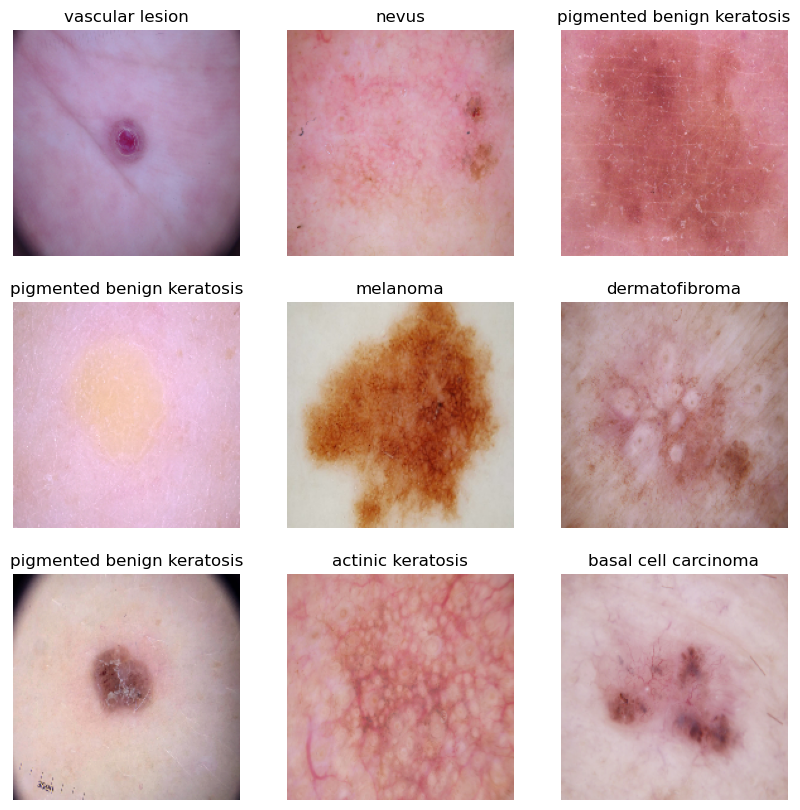

In [11]:
# Plotting one image per class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])  # Find the index of the max value in the one-hot encoded array
        plt.title(class_names[label_index])  # Use the index to retrieve the class name
        plt.axis("off")
plt.show()

# Model 1

In [12]:
# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
model = Sequential()

# Explicit Input layer to define the input shape
model.add(Input(shape=(img_height, img_width, 3)))

# Rescaling layer to normalize pixel values
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(9))
model.add(Activation('softmax'))

In [14]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    66,355,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,425,897 (253.39 MB)

 Trainable params: 66,425,897 (253.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
for images, labels in train_ds.take(1):
    print("Image batch shape: ", images.shape)
    print("Label batch shape: ", labels.shape)
    print("Sample labels: ", labels)

Image batch shape:  (32, 180, 180, 3)
Label batch shape:  (32, 9)
Sample labels:  tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

2024-06-12 18:26:03.518117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20


2024-06-12 18:26:03.965389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.2130 - loss: 3.3898 - val_accuracy: 0.2774 - val_loss: 1.9253
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.3145 - loss: 1.8804 - val_accuracy: 0.3870 - val_loss: 1.6493
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.3619 - loss: 1.7743 - val_accuracy: 0.3848 - val_loss: 1.7053
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.4095 - loss: 1.6423 - val_accuracy: 0.3803 - val_loss: 1.6635
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.5074 - loss: 1.4281 - val_accuracy: 0.4966 - val_loss: 1.4953
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5194 - loss: 1.3484 - val_accuracy: 0.5056 - val_loss: 1.5032
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.5837 - loss: 1.1480 - val_accuracy: 0.4966 - val_loss: 1.5488
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6588 - loss: 0.9765 - val_accuracy: 0.532

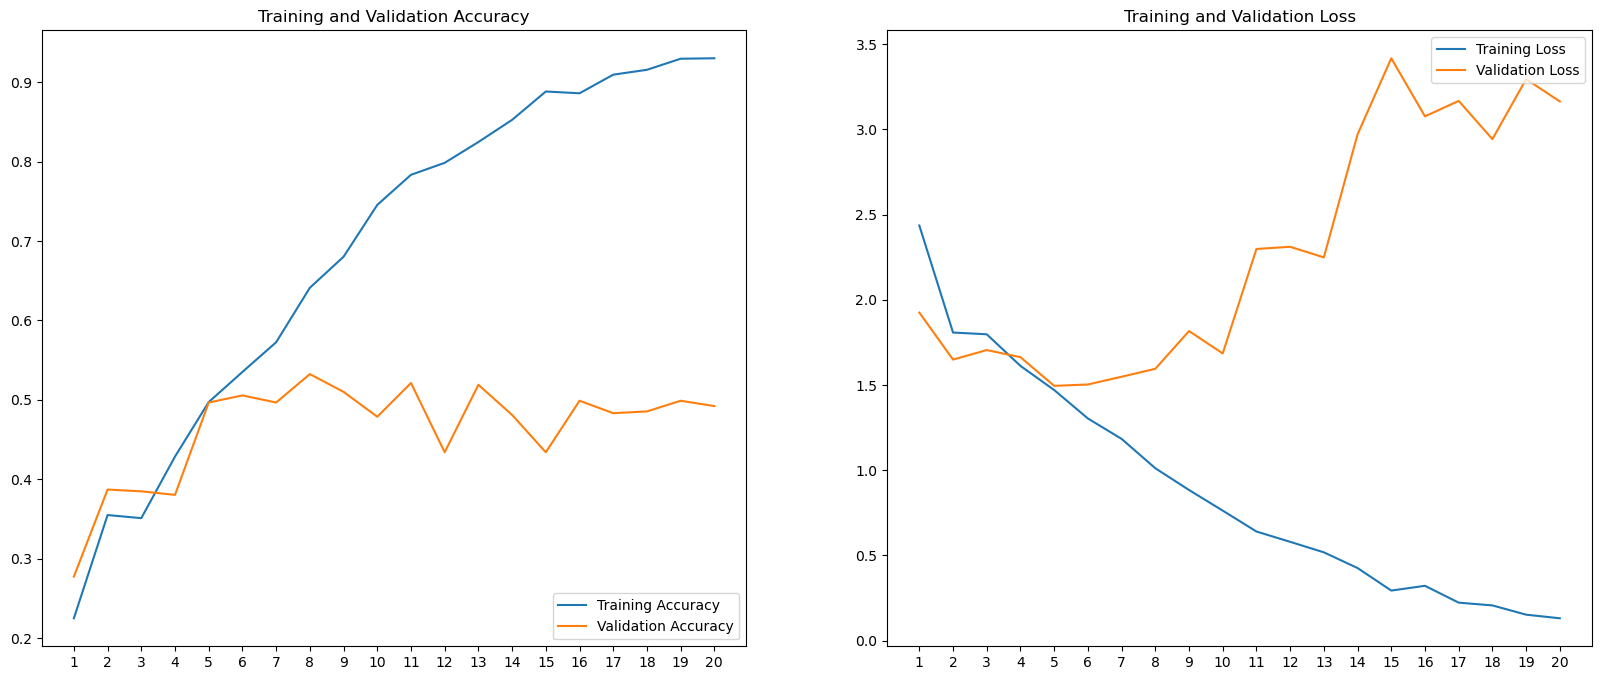

In [18]:
utils.plot_training_history(history)

In [19]:
# Evaluate the model on the test dataset
utils.evaluate_model(test_ds, model=model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.2694 - loss: 7.4863
Test Loss: 7.283335208892822
Test Accuracy: 0.2881355881690979


## Findings
- The model appears to be overfitting, as indicated by almost 45% disparity between the training and validation accuracies.
- This suggests that the model still needs to learn more features to generalize better on unseen data.

# Data Augmentation

In [20]:
# Define data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

* Visualizing how the augmentation strategy works for one instance of training image.

2024-06-12 18:33:05.570687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


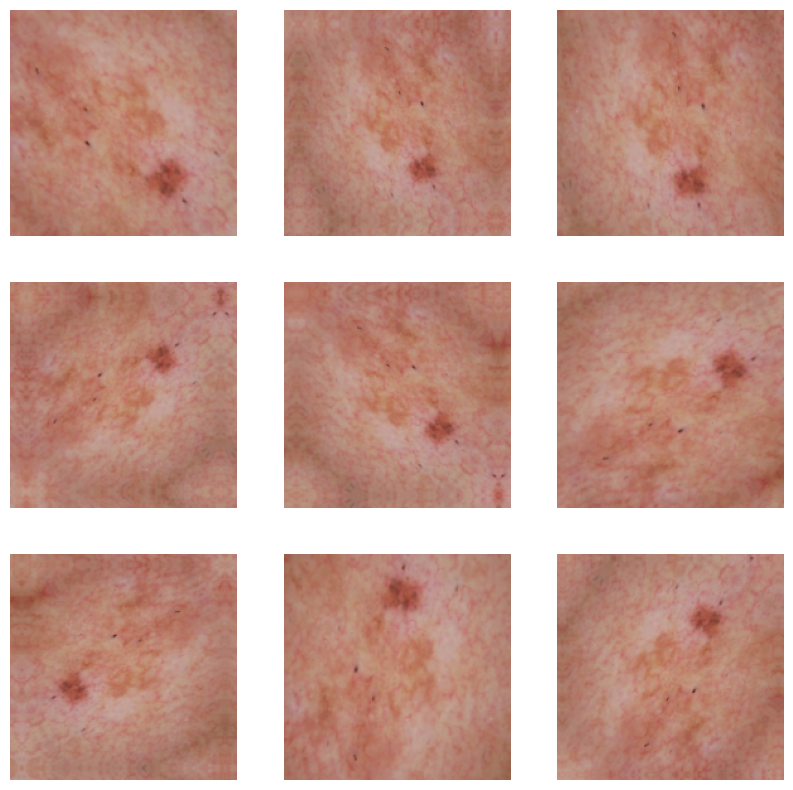

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model 2

In [22]:
# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
model = Sequential()

# Explicit Input layer to define the input shape
model.add(data_augmentation)

# Rescaling layer to normalize pixel values
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(9))
model.add(Activation('softmax'))


In [24]:
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.2079 - loss: 2.8473 - val_accuracy: 0.3221 - val_loss: 1.8367
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.3606 - loss: 1.7748 - val_accuracy: 0.4273 - val_loss: 1.6734
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3928 - loss: 1.6736 - val_accuracy: 0.4139 - val_loss: 1.6808
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4451 - loss: 1.5652 - val_accuracy: 0.4743 - val_loss: 1.5693
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4394 - loss: 1.6043 - val_accuracy: 0.3982 - val_loss: 1.6636
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4650 - loss: 1.5298 - val_accuracy: 0.4609 - val_loss: 1.5412
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.4695 - loss: 1.4690 - val_accuracy: 0.4787 - val_loss: 1.5186
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.5051 - loss: 1.4049 - val_accu

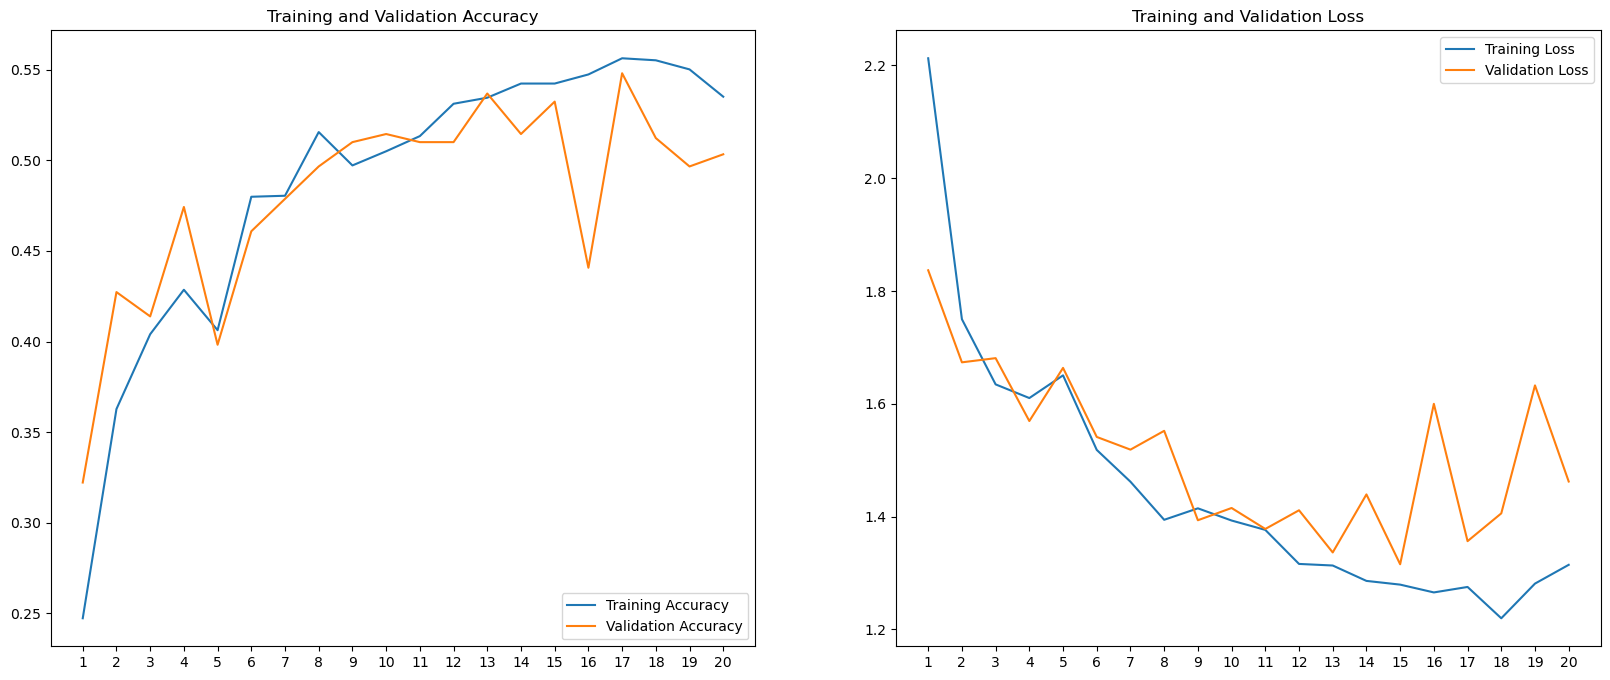

In [26]:
utils.plot_training_history(history)

In [27]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.3046 - loss: 2.3493
Test Loss: 2.302769899368286
Test Accuracy: 0.31355932354927063


## Finding
- With the inclusion of data augmentation layer, the model's overfitting has been significantly mitigated. Previously, there was a substantial 45% gap between training and validation accuracy, which has now narrowed to just 5%. However, the overall accuracy of the model has somewhat decreased compared to the initial vanilla model.

- Given these observations, there is still considerable room for further enhancement of the model's performance.

# Analyzing the Class Imbalance

2024-06-12 18:39:14.793786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 3000x800 with 0 Axes>

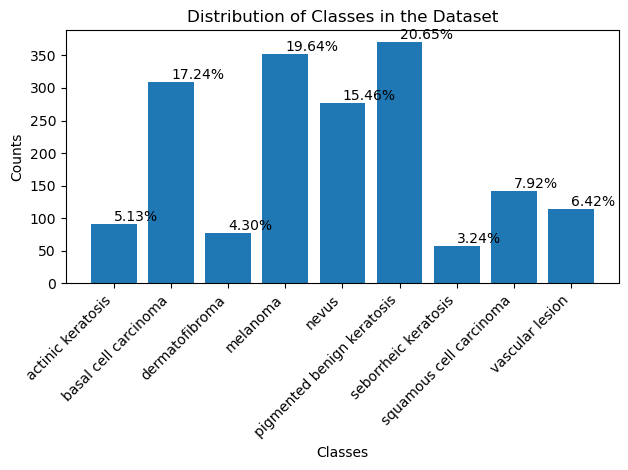

In [28]:
utils.plot_class_distribution(train_ds, class_names)

## Finding
- The dataset is highly imbalanced.
- Seborrheic Keratosis has the fewest samples.
- The most represented classes in the dataset, in descending order of sample size, are:
    - Pigmented Benign Keratosis
    - Melanoma
    - Basal cell carcinoma
    - Nevus
- Classes with the least representation, in ascending order of sample size, include:
    - Seborrheic Keratosis
    - Dermatofibroma
    - Actinic Keratosis
    - Vascular lesion
    - Squaous cell carcinoma

# Addressing class imbalance and augmenting images using the Augmentor library

In [29]:
utils.remove_output_dir(data_dir_train=data_dir_train)

In [30]:
#Augment each class to ensure a minimum number of samples
for class_name in class_names:
    p = Augmentor.Pipeline(os.path.join(data_dir_train, class_name))
    # Adding transformations
    # Randomly flip images horizontally and vertically with a probability of 0.5
    p.flip_left_right(probability=0.8)
    p.flip_top_bottom(probability=0.8)

    # Apply random zoom with a probability of 0.5 and zoom to up to 80% of the image area
    p.zoom_random(probability=0.5, percentage_area=0.8)

    # Run the pipeline
    p.sample(1000)


# Count augmented images
augmented_image_count = len(list(pathlib.Path(data_dir_train).glob('*/output/*.jpg')))
print(f"Total number of augmented images: {augmented_image_count}")


Initialised with 114 image(s) found.
Output directory set to skin_cancer_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x481B0C7C0>: 100%|██████████| 1000/1000 [00:02<00:00, 384.50 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to skin_cancer_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3E641A530>: 100%|██████████| 1000/1000 [00:03<00:00, 320.72 Samples/s]                 


Initialised with 95 image(s) found.
Output directory set to skin_cancer_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x434645E10>: 100%|██████████| 1000/1000 [00:02<00:00, 391.34 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to skin_cancer_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x4351DBDF0>: 100%|██████████| 1000/1000 [00:08<00:00, 113.07 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to skin_cancer_data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3EAE4B4F0>: 100%|██████████| 1000/1000 [00:08<00:00, 118.88 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to skin_cancer_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x4331E8A30>: 100%|██████████| 1000/1000 [00:02<00:00, 367.93 Samples/s]                 


Initialised with 77 image(s) found.
Output directory set to skin_cancer_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x4331CB400>: 100%|██████████| 1000/1000 [00:04<00:00, 205.08 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to skin_cancer_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3EAE4B5E0>: 100%|██████████| 1000/1000 [00:02<00:00, 367.63 Samples/s]                 


Initialised with 139 image(s) found.
Output directory set to skin_cancer_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3E641A620>: 100%|██████████| 1000/1000 [00:02<00:00, 390.20 Samples/s]                 


Total number of augmented images: 9000


In [31]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]

dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

print("Distribution of classes after augmentation:")
print(df2['Label'].value_counts())

Distribution of classes after augmentation:
Label
melanoma                      1000
pigmented benign keratosis    1000
nevus                         1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: count, dtype: int64


In [32]:
# Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, 
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')


Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [33]:
# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Assuming the validation data is in the same directory and you're splitting it
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [34]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 118 files belonging to 9 classes.


# Model 3

In [79]:
# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
model = Sequential()

# Explicit Input layer to define the input shape
model.add(Input(shape=(img_height, img_width, 3)))

# Rescaling layer to normalize pixel values
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(9))
model.add(Activation('softmax'))

In [81]:
# Print the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_80 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_81 (Activation)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 22, 22, 128)    │             

 Total params: 1,839,145 (7.02 MB)

 Trainable params: 1,838,761 (7.01 MB)

 Non-trainable params: 384 (1.50 KB)

In [82]:
opt = Adam(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [83]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)


Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 272ms/step - accuracy: 0.2102 - loss: 7.3741 - val_accuracy: 0.1130 - val_loss: 5.0231
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 76s 271ms/step - accuracy: 0.3842 - loss: 3.9135 - val_accuracy: 0.3471 - val_loss: 3.2069
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.4205 - loss: 2.7522 - val_accuracy: 0.4504 - val_loss: 2.3196
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.4365 - loss: 2.2770 - val_accuracy: 0.4677 - val_loss: 2.0395
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.4517 - loss: 1.9979 - val_accuracy: 0.4784 - val_loss: 1.8423
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 76s 271ms/step - accuracy: 0.4746 - loss: 1.8160 - val_accuracy: 0.4984 - val_loss: 1.7107
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 76s 271ms/step - accuracy: 0.4821 - loss: 1.6883 - val_accuracy: 0.5056 - val_loss: 1.5899
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 266ms/step - accuracy: 0.5037 - loss: 1

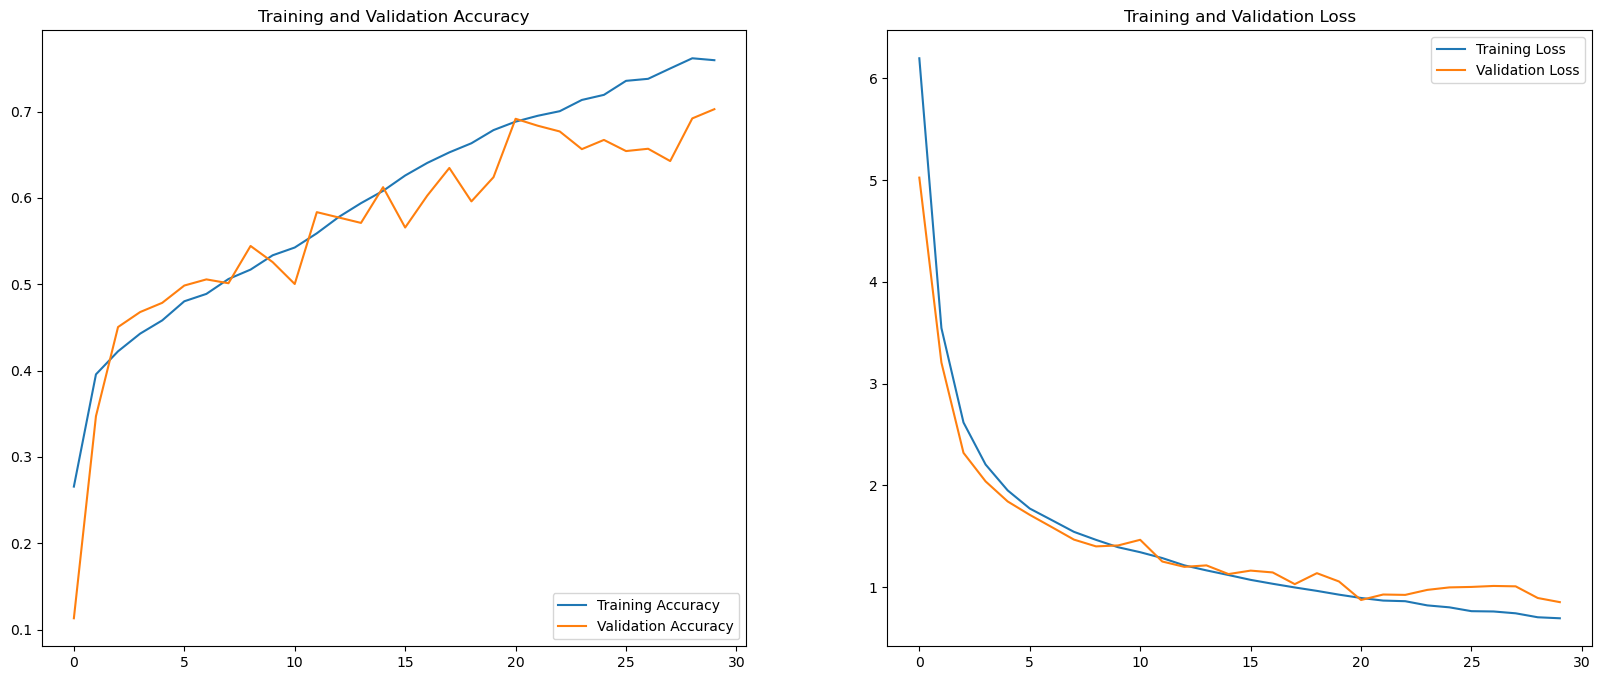

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.3895 - loss: 2.9765
Test Loss: 2.9003984928131104
Test Accuracy: 0.39830508828163147


## Finding 
- After using Augmentor to augment the images, the class imbalance issue has been resolved. 
- We observed a notable improvement in training accuracy (75%) and validation accuracy (70%), which is better than that of model 2. 
- Initially, in model 1, there was a significant 45% disparity between training and validation accuracies, which has now been reduced to a mere 5%, aligning it with the performance of model 2. 
- Nevertheless, there is still potential for further enhancement in accuracy.